In [6]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
#from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number


# from sklearn.calibration import calibration_curve
# from sklearn.utils import resample
# from sklearn.metrics import mean_squared_error

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def get_files_containing_words(directory, keywords):
    """
    creates list of all file name strings containing desired keywords

    Args:
        directory (string) : directory where files are stored
        keywords (list): list of desired keywords
    Returns:
        filtered_files (list) : list of filtered file names with desired keywords
    """

    # Get the list of all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that contain any of the specified words
    filtered_files = [file for file in all_files if any(word in file for word in keywords)]
    
    return filtered_files


def wsa_date_from_string(file_string):

    """
    extracts date from wsa filename

    Args:
        file_string (string) : wsa model solution file name string
    Returns:
        date_string (string) : date string generated from info within file string format
    """

    # Define regular expression pattern to extract the date
    pattern = r'%2F(\d{4})%2F(\d{1,2})%2F(\d{1,2})%2F'

    # Search for the pattern in the file string
    match = re.search(pattern, file_string)

    if match:
        year, month, day = match.groups()
        date_string = f'{year}-{month}-{day}'
    else:
        print("No date found in the string")

    return date_string

def earth_latitude_wsa(filename):

    """
    creates list of all file name strings containing desired keywords

    Args:
        filename (string) : wsa model solution file name
    Returns:
        E_lat (float) : average heliolatitude of Earth during timeframe of WSA solution in radians 
    """
        
    # HUXt model parameters
    dt_scale = 4
    r_min = 21.5 * u.solRad
    forecast_window = 27 * u.day

    # getting velocity profile and start time and cr longitude
    init_wsa_date = wsa_date_from_string(filename)
    cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date))

    # Use the HUXt ephemeris data to get Earth lat over the CR
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                        cr_lon_init=cr_lon_init, lon_out=0.0*u.deg, r_min = r_min)

    # Retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')

    # Get average Earth lat
    E_lat = np.nanmean(earth.lat_c)

    return E_lat


def interpolate_vmap(velocity_map, lats, longs):
    """
    Generates an interpolated solution of velocity map ready for sub-earth path extraction

    Args:
        velocity_map (2D array) : coronal model velocity map, shape (n x m)
        lats (array) : latitudinal coords along inner boundary, array of size n
        longs (array) : longitudinal coords along inner boundary, array of size m
    Returns:
        Int_2D_solution (object) : interpolation solution object
    """
    # Generate coordinate grid using n x m defined by length of lats and longs array
    #lat, long = np.mgrid[:len(lats), :len(longs)]

    long, lat = np.meshgrid(longs, lats)

    # This is an array with the shape 2,X --> formatted coordinate grid for interpolation
    X2D = np.array([long.flatten(), lat.flatten()]).T  

    # Run interpolation on velocity map
    Int_2D_solution = scipy.interpolate.LinearNDInterpolator(X2D, velocity_map.flatten())

    return Int_2D_solution

def gen_ensemble_perturbed_boundary_path(E_lat, longitudes, ensemble_size, sigma_latitude):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
    Returns: 
    """

    rng = np.random.default_rng() # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution
    lat_deviations = rng.normal(loc = E_lat, scale = sigma_latitude, size = ensemble_size) # max deviation sourced from gaussian with sigma_lat width

    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_paths.append(E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off))

    return perturbed_paths * u.rad

def extract_interpolated_velocity_boundary(interpolated_map_solution, boundary, longitudes):
    """
    generates velocity profile across longitudes along perturbed boundary from an interpolated coronal model solution

    Args:
        interpolated_map_solution (object) : interpolation solution object
        boundary (array) : perturbed latitudinal coordinates along inner boundary
        longitudes (array) : longitudinal coords along inner boundary
        
    Returns:
        velocity_boundary (array) : interpolated velocities across longitude (along the inner boundary)
    """

    velocity_boundary = interpolated_map_solution(longitudes, boundary)

    return velocity_boundary

In [16]:
# get all WSA files
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['wsa'] # keywords to filter for in coronal model file directory

# create wsa filepaths
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)
wsafilepaths = [os.path.join(directory_path, fname) for fname in wsa_fnames]

# getting velocity profile and start time and cr longitude
v_wsa = Hin.get_WSA_long_profile(wsafilepaths[0], lat=0.0 * u.deg)
init_wsa_date = wsa_date_from_string(wsa_fnames[0])
cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date))

# set up and run the models. WSA at 21.5 rS
model = H.HUXt(v_boundary=v_wsa, cr_num=cr, cr_lon_init=cr_lon_init, simtime=10*u.day, dt_scale=4, r_min = 21.5*u.solRad)
model.solve([])

# extract Earth time series dataFrame
df_forecast = HA.get_observer_timeseries(model, observer = 'Earth')


# plt.plot(df_forecast['time'], df_forecast['vsw'])
# plt.xticks(rotation = 45)
# plt.xlabel('Time [UTC]')
# plt.ylabel(r'$V_{SW}$ [km/s]')
# plt.show()


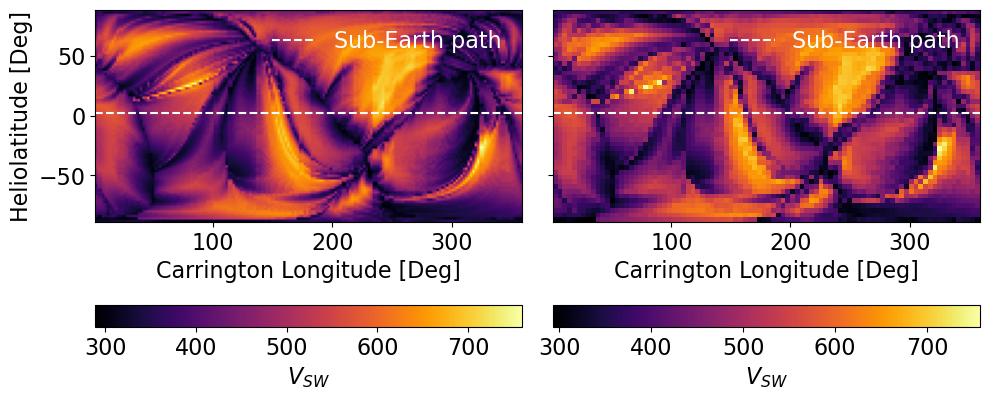

In [17]:
WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(wsafilepaths[0])

INT = interpolate_vmap(WSA_vr_map.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat = earth_latitude_wsa(filename = wsa_fnames[0])

long, lat = np.meshgrid(WSA_vr_longs.value[::2], WSA_vr_lats.value[::2])
IntPred = INT(long, lat)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6), sharey = True)

im0 = axes[0].imshow(WSA_vr_map.value, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

axes[0].axhline(E_lat.to(u.deg).value, color = 'white', linestyle = '--', label = 'Sub-Earth path')
#axes[0].set_colorbar(label = r'$V_{SW}$', orientation = 'horizontal', aspect = 30)
axes[0].set_xlabel('Carrington Longitude [Deg]')
axes[0].set_ylabel('Heliolatitude [Deg]')
axes[0].legend(frameon = False, labelcolor = 'linecolor')

im1 = axes[1].imshow(IntPred, cmap = 'inferno', 
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

axes[1].axhline(E_lat.to(u.deg).value, color = 'white', linestyle = '--', label = 'Sub-Earth path')
axes[1].set_xlabel('Carrington Longitude [Deg]')
axes[1].legend(frameon = False, labelcolor = 'linecolor')

fig.colorbar(im0, ax = axes[0], orientation = 'horizontal', label = r'$V_{SW}$')
fig.colorbar(im1, ax = axes[1], orientation = 'horizontal', label = r'$V_{SW}$')

plt.tight_layout()
plt.show()

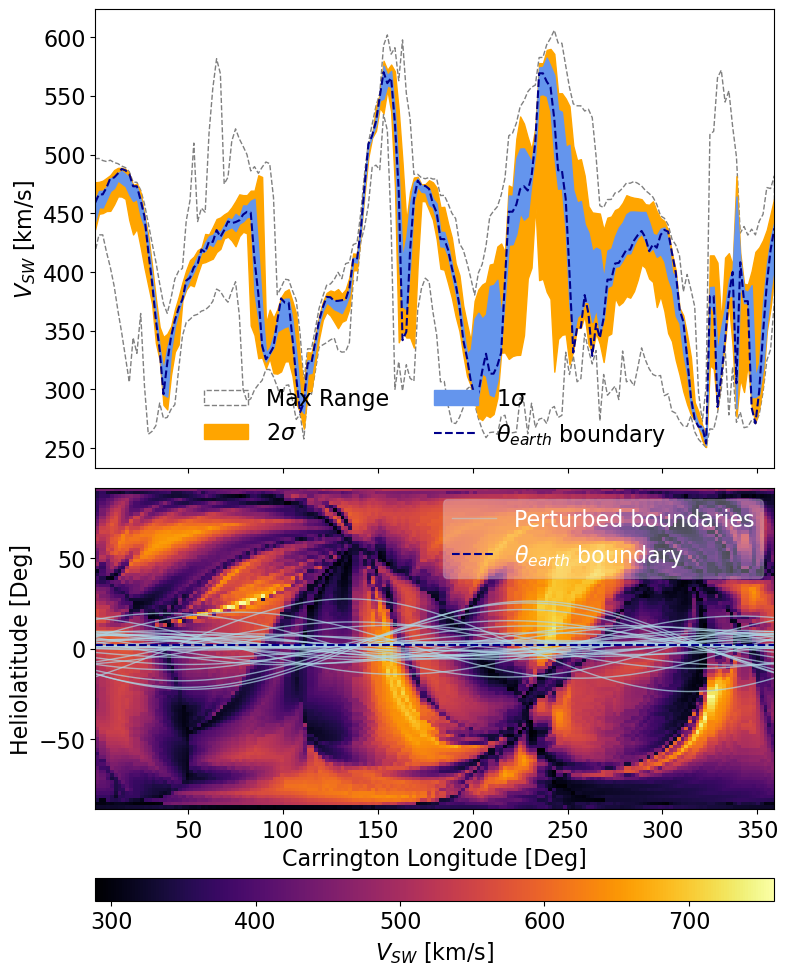

In [55]:
sigma_latitude = 10
ensemble_size = 30
# get all WSA files
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['wsa'] # keywords to filter for in coronal model file directory

# create wsa filepaths
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)
wsafilepaths = [os.path.join(directory_path, fname) for fname in wsa_fnames]

wsa_index = 0

WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(wsafilepaths[wsa_index])

# deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
vr_map_deacc = WSA_vr_map.copy()
for nlat in range(1, len(WSA_vr_lats)):
    vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad, WSA_vr_longs, 21.5 * u.solRad)

INT = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat = earth_latitude_wsa(filename = wsa_fnames[wsa_index]) 

perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                           ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitude))

velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=boundary.value, longitudes=WSA_vr_longs.value) 
                       for boundary in perturbed_boundary_paths]

#plt.figure(dpi = 300)
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8,10), sharex = True)

im = axes[1].imshow(vr_map_deacc.value, cmap = 'inferno', aspect = 'auto',
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

for boundary in perturbed_boundary_paths:
    axes[1].plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'lightblue', lw = 1, alpha = 0.7)

axes[1].plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'lightblue', lw = 1, alpha = 0.5, label = 'Perturbed boundaries')
#axes[1].plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'blue', lw = 1, alpha = 0.5)
axes[1].axhline(E_lat.to(u.deg).value, color = 'darkblue', linestyle = '--', label = r'$\theta_{earth}$ boundary')

fig.colorbar(im0, ax = axes[1], label = r'$V_{SW}$ [km/s]', orientation = 'horizontal', aspect = 30)#, location = 'bottom')
axes[1].set_xlabel('Carrington Longitude [Deg]')
axes[1].set_ylabel('Heliolatitude [Deg]')

axes[1].legend(framealpha = 0.3, labelcolor = 'white')

# for vr_boundary in velocity_boundaries:
#     axes[1].plot(WSA_vr_longs.to(u.deg).value, vr_boundary, color = 'grey')

axes[0].fill_between(WSA_vr_longs.to(u.deg).value, np.min(velocity_boundaries, axis = 0), np.max(velocity_boundaries, axis = 0), 
                     linestyle = '--', color = 'grey', facecolor = 'None', label = 'Max Range')

axes[0].fill_between(WSA_vr_longs.to(u.deg).value, np.percentile(velocity_boundaries,13.6, axis = 0), np.percentile(velocity_boundaries, (100-13.6), axis = 0),
                     edgecolor = 'None', label = r'2$\sigma$', color = 'orange')
axes[0].fill_between(WSA_vr_longs.to(u.deg).value, np.percentile(velocity_boundaries,34, axis = 0), np.percentile(velocity_boundaries, 68, axis = 0),
                     edgecolor = 'None', label = r'1$\sigma$', color = 'cornflowerblue')


axes[0].plot(WSA_vr_longs.to(u.deg).value, INT(WSA_vr_longs.value, np.ones(180)*E_lat.value), 
             color = 'darkblue', linestyle = '--', label = r'$\theta_{earth}$ boundary')
axes[0].set_ylabel(r'$V_{SW}$ [km/s]')
axes[0].legend(frameon = False, ncols = 2)


plt.tight_layout()
plt.show()


In [62]:
def generate_ensemble_forecast(params):

    """
    creates an ensemble of HUXt model runs by spatially perturbing inner boundary

    Args:
        params (tuple) : contains information needed to generate ensemble

        ----------------------- FORMAT
        format : (filname, ensemble_size, sigma_latitude, forecast_window, r_min) 
        filename (string) : name of coronal model file name
        ensemble_size (int) : number of ensemble members
        sigma_latitude (float) : scale paramater which controls spread of intial conditions in degrees
        forecast_window (float) : duration of model run/forecast length in units of days
        r_min (float) : distance of inner boundary from Sun in units of solar radii 
        
    Returns:
        ensemble_members (list) : list of dataFrames of model runs, timeseries extracted at Earth
    """

    # Extract ensemble information
    filename = params[0]
    ensemble_size = params[1]
    sigma_latitude = np.radians(params[2])
    forecast_window = params[3]
    r_min = params[4] # WSA at 21.5 rS

    rng = np.random.default_rng() # Initialise random number generator

    # filepath for accessing wsa files
    directory_path = H._setup_dirs_()['boundary_conditions']
    filepath = os.path.join(directory_path, filename)

    # get WSA velocity map and create interpolation solution
    WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(filepath)

    # deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
    vr_map_deacc = WSA_vr_map.copy()
    for nlat in range(1, len(WSA_vr_lats)):
        vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad,
                                                            WSA_vr_longs, 21.5 * u.solRad)

    INT = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)

    # forecast characteristics
    E_lat = earth_latitude_wsa(filename = filename) # sub earth path as basis for 'true' initial conditions
    init_wsa_date = wsa_date_from_string(filename) # forecast start time
    cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date)) # start time translated into carrington rotation + longitudinal component

    # Generate perturbed inner boundary paths
    perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                            ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitude))

    # Generate ensemble of interpolated near-sun velocity boundaries
    velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=boundary.value, longitudes=WSA_vr_longs.value) 
                        for boundary in perturbed_boundary_paths]

    # Initialise ensemble member list
    ensemble_members = []

    for v_boundary in velocity_boundaries:

        # set up and run HUXt model. 
        model = H.HUXt(v_boundary=v_boundary*(u.km/u.s), cr_num=cr, cr_lon_init=cr_lon_init, simtime=forecast_window, dt_scale=4, r_min = r_min)
        model.solve([])

        # Extract Earth time series dataFrame
        df_earth_series = HA.get_observer_timeseries(model, observer = 'Earth')
        df_earth_series = df_earth_series.rename(columns = {'time':'datetime'}) # rename time column to match OMNI dataframe format (for ease later on)
        df_earth_series['datetime'] = df_earth_series['datetime'].values.astype(dtype='datetime64[ns]') # setting index to datetime ready for longitudinal perturbation
        df_earth_series = df_earth_series.set_index('datetime')
        ensemble_members.append(df_earth_series.copy())

    return ensemble_members

    

In [57]:
def save_ens_to_cdf(ensemble_members, date_string, sigma_latitude, ensemble_size, coronal_model):
    """
    saves an ensemble set to a netcdf4 file.
    saved files indexed by ensemble size, forecast start time, sigma_latitude, and the coronal model used to generate the ensemble

    Args:
        ensemble_members (list) : list of dataFrames of model runs, timeseries extracted at Earth
        date_string (string) : date string generated from wsa filename
        sigma_latitude (float) : scale paramater which controls spread of intial conditions in degrees
        ensemble_size (int) : number of ensemble members
        coronal_model (string) : name of coronal model used to generate ensnemble
        
    Returns:
        None

    """

    # Convert list of panda dataframes into single xarray dataset along new index 'ensemble member'
    ds_ = xr.concat([df.to_xarray() for df in ensemble_members], dim="ensemble_members")
    
    # Create/find folder indexed by sigma_latitude, ensemble_size, and coronal_model
    dir_name = f'ens_{int(sigma_latitude)}_{ensemble_size}_{coronal_model}'

    # create directory to save ensemble to
    directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    dir_path = os.path.join(directory_path, dir_name)
    
    if not os.path.exists(dir_path):
        os.mkdir(dir_path) 


    date_num = re.sub('[-/_]','',date_string)
    # Generate filename for ensemble set (marked by carrington rotation)
    ensemble_fname = f'ens_{int(sigma_latitude)}_{ensemble_size}_{coronal_model}_{date_num}.nc'

    output_file = os.path.join(directory_path, dir_name, ensemble_fname)
    
    # Save the dataset to a NetCDF file
    ds_.to_netcdf(output_file, engine = 'netcdf4')

    return

def read_ens_cdf(date_string, sigma_latitude, ensemble_size, coronal_model):
    """
    reads in netcdf4 file containing an ensemble
    saved files indexed by ensemble size, forecast start time, sigma_latitude, and the coronal model used to generate the ensemble

    Args:
        date_string (string) : date string generated from wsa filename
        sigma_latitude (float) : scale paramater which controls spread of intial conditions in degrees
        ensemble_size (int) : number of ensemble members
        coronal_model (string) : name of coronal model used to generate ensnemble
        
    Returns:
        df_list (list) : list of dataFrames of model runs, timeseries extracted at Earth

    """
    date_num = re.sub('[-/_]','',date_string)
    
    # Create/find folder indexed by sigma_latitude, ensemble_size, and coronal_model
    ens_dir_name = f'ens_{int(sigma_latitude)}_{ensemble_size}_{coronal_model}'
    ensemble_fname = f'ens_{int(sigma_latitude)}_{ensemble_size}_{coronal_model}_{date_num}.nc'
    #input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\ensembles\\{dir_name}\\{ensemble_fname}'

    # filepath to read file from
    data_dir_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    ens_dir_path = os.path.join(data_dir_path, ens_dir_name)
    input_file = os.path.join(ens_dir_path, ensemble_fname)

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    # Initialize an empty list to store DataFrames
    df_list = []

    # Loop through ensemble members xarray dimension, convert each member to pandas dataframe, append to list
    for i in range(ensemble_size):
        df_list.append(loaded_ds.sel(ensemble_members = i).to_dataframe())

    return df_list

In [58]:
# get all WSA files
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['wsa'] # keywords to filter for in coronal model file directory
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)

#test params
ensemble_size = 10
sigma_latitude = 40 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad

# params formatted as a tuple to feed to ensemble gen function
params = (wsa_fnames[0], ensemble_size, sigma_latitude, forecast_window, r_min)

ensemble_members = generate_ensemble_forecast(params=params)


In [59]:
date_string = wsa_date_from_string(params[0])
save_ens_to_cdf(ensemble_members=ensemble_members, date_string=date_string, sigma_latitude=params[2], ensemble_size=params[1], coronal_model='wsa')


In [60]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

In [28]:
def interpolate_and_resample(observed_data, forecast_series):
    
    """
    interpolates forecast timeseries and resamples it onto the observed data timestep

    Args:
        observed_data (dataFrame) : observed near-Earth solar wind speed data
        forecast_series (dataFrame) : forecast time series
        
    Returns:
        interpolated_forecast_output (array) : resampled forecast time series onto observed data time step

    """
    Int = scipy.interpolate.CubicSpline(forecast_series.index, forecast_series['vsw'])
    
    data_time_axis = observed_data.index

    interpolated_forecast_output = Int(data_time_axis)

    return interpolated_forecast_output

In [29]:
def gen_ranked_ensemble(ensemble_members, observed_data): 

    """
    ranks an ensemble forecast (counts fraction of ensemble members overpredicting observed wind speed)

    Args:
        ensemble_members (list) : list of dataFrames of model runs, timeseries extracted at Earth
        observed_data (dataFrame) : observed near-Earth solar wind speed data
    
    Returns:
        summed_rank (array) : array with counts of ensemble members overprediscting windspeed per timestep
    """
    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    data_chunk = observed_data.loc[ensemble_members[0].index[0]:ensemble_members[0].index[-1]]
    data_chunk = data_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time ste[]
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(data_chunk, vsw)
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    ranked_forecast_boolean = np.array([vsw < data_chunk['V'] for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)

    return summed_ranks

In [30]:
def perturb_longitude(longitudinal_disp, ensemble_member):

    """
    perturbs an ensemble member longitudinally
    longitududinal perturbation is equivalent to a temporal displacement of ensemble member

    Args:
        longitudinal_disp (float) : angular displacement for longitudinal perturbation in units of radians
        ensemble_member (dataFrame) : single ensemble member dataframe
    
    Returns:
        perturbed_ensemble_member (dataFrame) : ensemble member shifted in time related by the longitudinal displacement

    """

    # convert angular displacement into a temporal displacement
    carrington_rotation = 27.2753*u.day
    long_pert_dt = ((longitudinal_disp * carrington_rotation.value) / (2*np.pi)) * u.day

    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype('int64') // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)

In [31]:
def generate_ensemble_statistics(ensemble_members):
    """
    computes ensemble statistics which characterise the ensemble spread per timestep. 
     - range (min/max)
     - ensemble median/mean
     - 1 sigma spread (upper/lower)
     - 2 sigma spread (upper/lower)

    Args:
        ensemble_members (list) : list of dataFrames timeseries from HUXt model runs
    
    Returns:
        statistics_df (dataFrame) : timeseries of relevant ensemble statistics in each column
    """
    
    # Concatenate dataframes
    combined_df = pd.concat(ensemble_members, axis=0)

    # Group by time 
    grouped_df = combined_df.groupby('datetime')['vsw']

    # Compute statistics
    min_values = grouped_df.min()
    max_values = grouped_df.max()
    median_values = grouped_df.median()
    mean_values = grouped_df.mean()
    lower_2s_percentile = grouped_df.quantile(0.14)
    upper_2s_percentile = grouped_df.quantile(0.86)
    lower_1s_percentile = grouped_df.quantile(0.34)
    upper_1s_percentile = grouped_df.quantile(0.68)

    # Combine statistics into a single dataframe
    statistics_df = pd.DataFrame({
        'min': min_values,
        'max': max_values,
        'median' : median_values,
        'mean' : mean_values,
        '1s_lower_percentile': lower_1s_percentile,
        '1s_upper_percentile': upper_1s_percentile,
        '2s_lower_percentile': lower_2s_percentile,
        '2s_upper_percentile': upper_2s_percentile
    })

    return statistics_df

In [32]:
def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
    """
    calculated rank histogram chi square value -- indication of histogram flatness

    Args:
        ensemble_size (int) : number of ensemble members
        ranked_forecast (array) : ranked forecast timeseries
    
    Returns:
        chi_sq (float) : chi squared value 
    """
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq = 0 
    
    for i in range(ensemble_size):
        # loop through each rank and follow summation formula
        chi_sq += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq = chi_sq*np.sum(ensemble_hist)*(ensemble_size+1) # scaling by n(n+1)

    return chi_sq

In [33]:
def generate_catagorical_forecast(forecast, event_threshold):
    """
    creates a catagorical forecast (binarises timeseries labelling events as 1 and 0 elsewhere)

    Args:
        forecast (array): array containing HUXt forecast time series
        event_threshold (float): Wind speed threshold which defines an event (events are characterised as forecast values above this)

    Returns:
        catagorical_forecast (numpy array): array containing catagorical/binary forecast
    """
    catagorical_forecast = forecast > event_threshold

    return catagorical_forecast.astype(int)


def gen_probabilistic_forecast(ensemble_members, event_threshold, ensemble_size): 
    """
    Converts a set of ensemble members into a probabilistic forecast based on a threshold.

    Args:
        ensemble_members (list): list of dataFrames timeseries from HUXt model runs
        event_threshold (float): Wind speed threshold value of forecast (above which forecast is catagorised as a 'hit')
        ensemble_size (int): Number of individual ensemble members
    
    Returns:
        probabilistic_forecast (array): probabilistic forecast timeseries (values between 0 and 1).
    """

    # Compare individual ensemble member forecast timeseries to chosen threshold
    forecast_event_instances = np.array([forecast > event_threshold for forecast in ensemble_members])

    # Sum along zeroth axis to count the number of ensemble members above threshold for each timestep
    summed_events = np.sum(forecast_event_instances, axis = 0) 

    return summed_events/ensemble_size # Normalise by ensemble size to get probabilities



In [34]:
def compute_calibration_curve_and_errors(ensemble_members, event_threshold, ensemble_size, observed_data, num_bins):

    """
    Converts a set of ensemble members into a probabilistic forecast based on a threshold.

    Args:
        ensemble_members (list) : list of dataFrames timeseries from HUXt model runs
        event_threshold (float) : Wind speed threshold value of forecast (above which forecast is catagorised as a 'hit')
        ensemble_size (int) : Number of individual ensemble members
        observed_data (dataFrame) : observed near-Earth solar wind speed data (omni)
        num_bins (int) : number of probability bins

    Returns:
        mean_probabilities (array) : mean forecast probabilties for each bin
        observed_frequency (array) : relative frequency of observed events within each bin
        obs_err (array) : sampling error for each bin based on poisson counting stats
    """

    # define terms for calibration curve: generating proabilistic forecast from ensemble, binarising observed timeseries by event threshold
    y_prob = gen_probabilistic_forecast(ensemble_members=ensemble_members, event_threshold=event_threshold, ensemble_size=ensemble_size)
    y_true = generate_catagorical_forecast(forecast=observed_data['V'], event_threshold=event_threshold)

    # Bin probabilities
    bins = np.linspace(0, 1, num_bins + 1) # Generate bins
    bin_indices = np.digitize(y_prob, bins) # Return the indices of the bins to which each value in input array belongs.

    # Calculate percentage correct in each bin
    observed_frequency = []
    obs_err = []

    for bin_num in range(1, num_bins + 1):
        mask = (bin_indices == bin_num) # Create mask which isolates all forecast indices within bin being looped over
        percentage = np.mean(y_true[mask]) # calculate percentage as fraction of correct forecasts of binned indices
        observed_frequency.append(percentage)
        obs_err.append(percentage/np.sqrt(np.sum(y_true[mask]))) # Error is calculated as mean/sqrt(N) (Poisson counting stats)

    # Calculate mean probability in each bin
    mean_probabilities = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

    #rmsd = rmsd_of_cal_curve((np.array(observed_frequency), np.array(mean_probabilities)))

    return mean_probabilities, observed_frequency, obs_err#, rmsd

In [35]:
def compute_brier_score(forecast, observed_data, event_threshold):
    """
    Calculates the Brier score

    Args:
        forecast (array) : Forecast timeseries values
        observed_data (array) : Array containing observed timeseries values
        event_threshold (float) : Wind speed threshold which defines an event (events are characterised as forecast values above this)

    Returns:
        brier_score (float) : Brier score metric of forecast skill (calibration + refinement).
    """

    y_obs = observed_data > event_threshold  # catagorising/binarizing observed events using threshold of interest
    y_forecast = forecast > event_threshold # catagorising/binarizing forecast using threshold of interest

    return np.mean((y_forecast.astype(float) - y_obs.astype(float)) ** 2)


def ensemble_brier_score(ensemble_members, observed_data, event_threshold, ensemble_size):
    """
    Calculates the Brier Score for a probabilistic forecast generated by an ensemble

    Args:
        ensemble_members (list) : list of dataFrames timeseries from HUXt model runs
        observed_data (dataFrame) : observed near-Earth solar wind speed data (omni)
        event_threshold (float) : Wind speed threshold which defines an event (events are characterised as forecast values above this)
        ensemble_size (int) : Number of ensemble members

    Returns:
        brier_score (float) : Brier score metric of forecast skill (calibration + refinement).
    """

    y_obs = observed_data > event_threshold  # catagorising/binarizing observed events using threshold of interest
    y_forecast = gen_probabilistic_forecast(ensemble_members, event_threshold, ensemble_size) 

    return np.mean((y_forecast - y_obs) ** 2)

Chi Squared = 5576.03, Brier Score = 0.00


C:\Users\ct832900\AppData\Local\Temp\ipykernel_11136\2827193582.py:35: RuntimeWarning: invalid value encountered in scalar divide
  obs_err.append(percentage/np.sqrt(np.sum(y_true[mask]))) # Error is calculated as mean/sqrt(N) (Poisson counting stats)


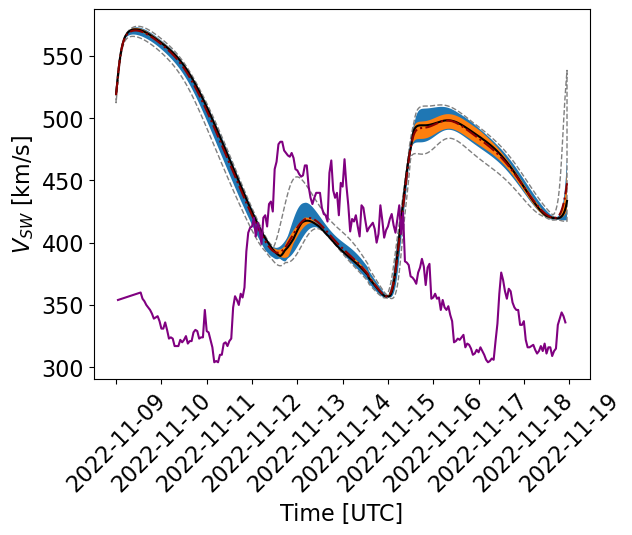

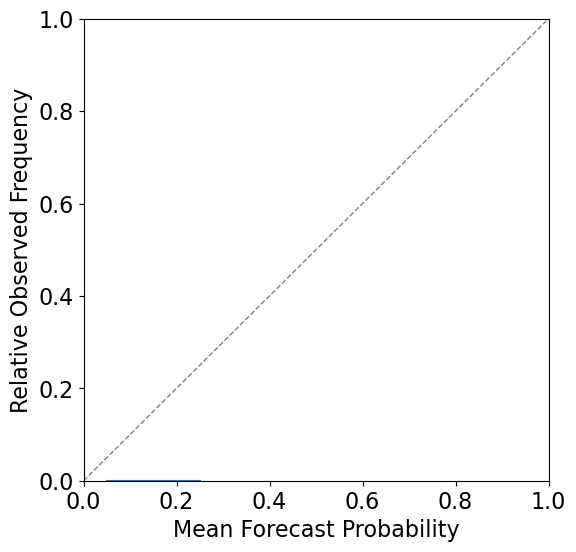

In [61]:
rng = np.random.default_rng() # Initialise random number generator

#test params
ensemble_size = 10
sigma_latitude = 40 # degrees
sigma_longitude = 0 # degrees
forecast_window = 10 * u.day
r_min = 21.5*u.solRad

# params formatted as a tuple to feed to ensemble gen function
params = (wsa_fnames[0], ensemble_size, sigma_latitude, forecast_window, r_min)
date_string = wsa_date_from_string(wsa_fnames[0])

test_ens_members = read_ens_cdf(date_string=date_string, sigma_latitude=params[2], ensemble_size=params[1], coronal_model='wsa')

longitudinal_displacement = rng.normal(loc = 0, scale = np.radians(sigma_longitude), size = ensemble_size)

lp_test_ens_members = []

for ens, long_disp in zip(test_ens_members, longitudinal_displacement):
    
    shifted_df = perturb_longitude(longitudinal_disp=long_disp, ensemble_member=ens)
    lp_test_ens_members.append(shifted_df)

statistics_df = generate_ensemble_statistics(ensemble_members=lp_test_ens_members)

data_chunk = omni_data.loc[lp_test_ens_members[0].index[0]:lp_test_ens_members[0].index[-1]]
data_chunk = data_chunk.dropna(subset = ['V']) # Remove rows with NaN values

resampled_ens = []

for ens in lp_test_ens_members:
    res_ens = interpolate_and_resample(observed_data=data_chunk['V'], forecast_series=ens)
    resampled_ens.append(res_ens)

# rank histogram + chi squared
ranked_forecast = gen_ranked_ensemble(ensemble_members=lp_test_ens_members, observed_data=omni_data)
chi_sq = calculate_rank_chi_square(ensemble_size=50, ranked_forecasts=ranked_forecast)

# reliability diagram
mean_prob, obs_rel_freq, obs_err = compute_calibration_curve_and_errors(ensemble_members=resampled_ens, event_threshold=550, ensemble_size=50, observed_data=data_chunk, num_bins=10)

# brier score + ROC curve
brier_score = ensemble_brier_score(ensemble_members=resampled_ens, observed_data=data_chunk['V'], event_threshold=550, ensemble_size=50)

print(f'Chi Squared = {chi_sq:.2f}, Brier Score = {brier_score:.2f}')

plt.fill_between(statistics_df.index, statistics_df['2s_lower_percentile'], statistics_df['2s_upper_percentile'] )
plt.fill_between(statistics_df.index, statistics_df['1s_lower_percentile'], statistics_df['1s_upper_percentile'] )
plt.fill_between(statistics_df.index, statistics_df['min'], statistics_df['max'], facecolor = 'none', edgecolor = 'grey', linestyle = '--' )
plt.plot(statistics_df.index, statistics_df['median'], color = 'black')
plt.plot(statistics_df.index, statistics_df['mean'], color = 'darkred', linestyle = '-.')
plt.plot(data_chunk['V'], color = 'purple')

plt.xlabel('Time [UTC]')
plt.ylabel(r'$V_{SW}$ [km/s]')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize=(6,6))
plt.errorbar(mean_prob, obs_rel_freq, yerr=obs_err)
plt.plot([0,1], [0,1],lw = 1, color = 'grey', linestyle ='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Mean Forecast Probability')
plt.ylabel('Relative Observed Frequency')
plt.show()

In [ ]:
def compute_ensemble_hit_false_rate(observed_data, ensemble_members, event_threshold, probability_threshold):
    """
    Computes the hit rate and false alarm rate of an input ensemble set.
    
    Args:
        ensemble_members (list) : list of dataFrames timeseries from HUXt model runs
        event_threshold (float) : Wind speed threshold which defines an event (events are characterised as forecast values above this)
        probability_threshold (float) : probability threshold for converting probabilistic forecast into a catagorical forecast (above which forecast is catagorised as a 'hit')

    Returns:
        (true_positive_rate, false_positive_rate) (tuple) : lists of hit rate and false alarm rate sorted within a tuple
    """
    # Catagorising/Binarising observed wind speed
    observed_positives = observed_data > event_threshold
    observed_negatives = observed_data < event_threshold

    # Create a catagorical/binary forecast from ensemble set
    forecast_positives = gen_catagorical_from_ensemble(ensemble_members=ensemble_members, event_threshold=event_threshold, probability_threshold=probability_threshold)
    forecast_negatives =(~forecast_positives.astype(bool)).astype(int)

    # Pick out numbers of true positives/false negatives/true negatives/false positives
    true_positives = np.sum(forecast_positives[observed_positives])
    false_negatives = np.sum(forecast_negatives[observed_positives])

    true_negatives = np.sum(forecast_negatives[observed_negatives])
    false_positives = np.sum(forecast_positives[observed_negatives])

    # Compute TPR and FPR, whilst taking into account edge cases where there are no events
    if (true_positives + false_negatives) == 0:
        true_positive_rate = np.nan
        false_positive_rate = false_positives / (false_positives + true_negatives)

    elif (false_positives + true_negatives) == 0:
        true_positive_rate = true_positives / (true_positives + false_negatives)
        false_positive_rate = np.nan
    
    elif (true_positives + false_negatives) and (false_positives + true_negatives) == 0:
        true_positive_rate = np.nan
        false_positive_rate = np.nan
    else:
        true_positive_rate = true_positives / (true_positives + false_negatives)
        false_positive_rate = false_positives / (false_positives + true_negatives)

 

    return (true_positive_rate, false_positive_rate)